<center> <h1> Lecture 7: Sequence Models: Recurrent Neural Networks and Transformers </h1> </center>
<center> Krishna Pillutla, Zaid Harchaoui </center>
    <center> Data 598 (Winter 2022), University of Washington </center>

In this lecture, we will talk about models which deal with sequential data. In particular, we talk about recurrent neural networks and transformer models.

The example in this notebook is based on [this PyTorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html).

# Part 1: Motivating Attention with Nearest Neighbors

The $k$-nearest neighbor approach to classification or regression is a classical non-parametric one. 

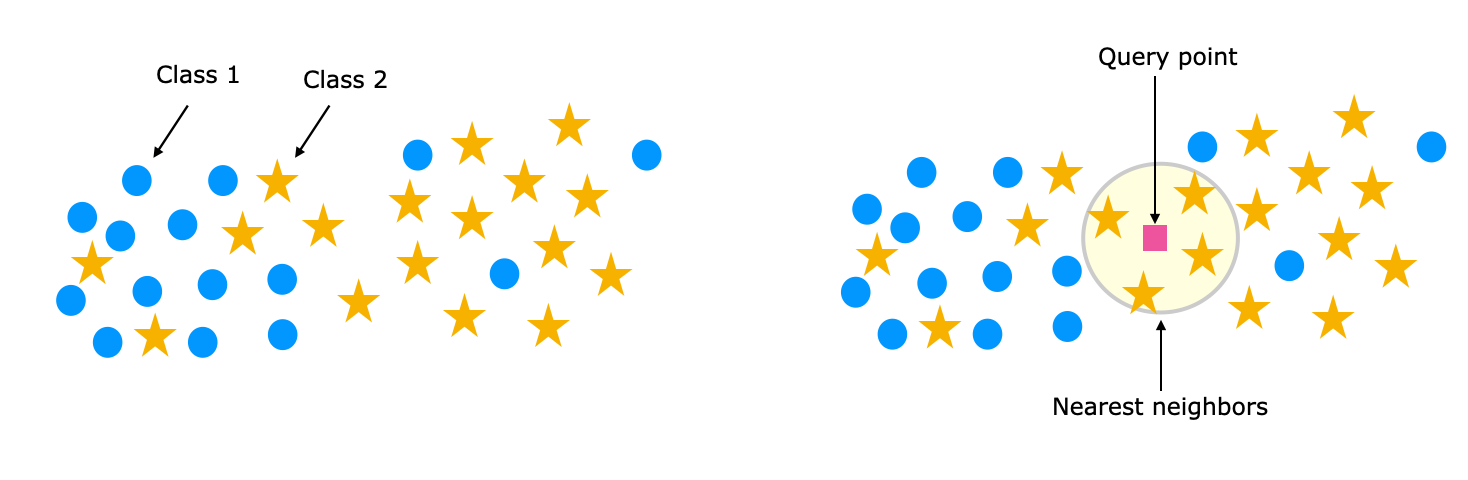

We consider the regression setting with labeled input-output pairs $(x_1, y_1), \cdots, (x_n, y_n) \in \mathbb{R}^d \times \mathbb{R}^m$. Given a query point $x' \in \mathbb{R}^d$, the $k$-nearest neighbor regression makes the prediction
$$
    y' = \frac{1}{k} \sum_{i \in N_k(x')} y_i \,,
$$
where $N_k(x') = \{i_1, \cdots i_k\}$ denotes the indices of the $k$ $x_i$'s nearest to the query point $x'$.


In this example, we use scalar-valued $x$ and $y$ (i.e., input dimension $d=1$ and output dimension $m=1$).

Text(0, 0.5, '$y$')

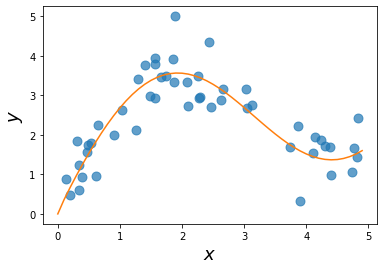

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n_train = 50  # No. of training examples
x_train = np.sort(np.random.rand(n_train) * 5)   # Training inputs

def f(x):
    return 2 * np.sin(x) + x**0.8

y_train = f(x_train) + np.random.normal(0.0, 0.5, (n_train,))  # Training outputs

x_test = np.arange(0, 5, 0.1)  # Testing examples
y_truth = f(x_test)  # Ground-truth outputs for the testing examples
n_test = len(x_test)  # No. of testing examples

plt.plot(x_test, y_truth, color='C1')

plt.scatter(x_train, y_train, alpha=0.7, color='C0', s=80)
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r'$y$', fontsize=18)


In [2]:
from sklearn.neighbors import KNeighborsRegressor
def knn_regression(k, x_query):
    # Assume x_query is a single query point (1D)
    # Return the prediction as a scalar
    # TODO: your code here
    diff = np.array([abs(x_query - x_val) for x_val in x_train])
    sorted_diff_idx = np.argsort(diff)
    y_vals = [y_train[i] for i in sorted_diff_idx[:k]]
    
    return (1/k) * sum(y_vals)

y_pred = [knn_regression(3, xq) for xq in x_test]
print(y_pred)

[1.0772700970961588, 1.0772700970961588, 1.0772700970961588, 1.238249376790687, 0.931881623134281, 1.693994173810458, 1.667899755122684, 1.667899755122684, 1.7336186076111268, 2.2884623061996785, 2.2443688398732267, 2.719801324744033, 2.719801324744033, 3.1039879341868453, 3.3904633884782793, 3.5796741200123763, 3.563577538050954, 3.292033095716301, 3.579784293631383, 4.083792986704673, 3.691622565552689, 3.183530746503969, 3.1222494710598845, 3.1222494710598845, 3.3396446991131215, 3.3114793348627303, 2.912434318690554, 2.912434318690554, 3.06119703863358, 2.8665633667507873, 2.8665633667507873, 2.8665633667507877, 2.8665633667507877, 2.8665633667507877, 2.379209652422958, 2.231209322548658, 1.4187734512504826, 1.4187734512504826, 1.4187734512504826, 1.418773451250483, 1.3724424573221443, 1.7889018224070905, 1.7889018224070905, 1.7639437727987284, 1.4691444348162968, 1.4691444348162968, 1.240238743530917, 1.3930212832949675, 1.8469506547555565, 1.8469506547555565]


Text(0, 0.5, '$y$')

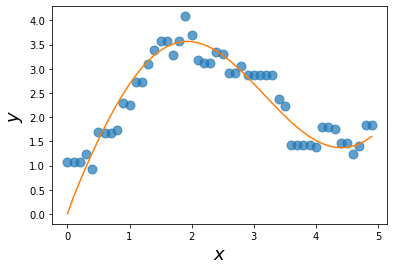

In [3]:
plt.plot(x_test, y_truth, color='C1')
plt.scatter(x_test, y_pred, color='C0', s=80, alpha=0.7,)
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r'$y$', fontsize=18)


## From kNN to Attention

Given input-output pairs $(x_1, y_1), \cdots, (x_n, y_n) \in \mathbb{R}^d \times \mathbb{R}^m$ and a query point $x'$, 
a general attention mechanism returns the output
$$
     p(x') = \sum_{i=1}^n S(x_i, x') y_i \,,
$$
where $S(x_i, x')$ is some measure of similarity between $x_i$ and $x'$. 

Here,  the $x_i$'s are called *keys*, and the $y_i$'s are called values. The query point $x'$ is compared against each of the $n$ keys; their similarity weight $S(x_i, x')$ scales is the weight of the contribution of the corresponding values $y_i$.

**Exercise**: Instantiate the similarity function $S(x_i, x)$ corresponding to the $k$-NN model.

In this lecture, we focus on **scaled dot-product attention**, where the similarity function is defined as
$$
    S(x_i, x') \propto \exp\left(\frac{x_i^\top x'}{\sqrt{d}}\right) \,.
$$
Here, the scores are normalized to sum to $1$ (so that we actually take a weighted _average_, not just a weighted sum), and $d$ is the dimensionality of the key $x_i$ and the query $x'$. 

**Exercise ($\sqrt{d}$-scaling)**: If the entries of $x_i$ and $x'$ are all independent and identically distributed as $N(0, 1)$ (i.e., standard normal), then show that $S(x_i, x')$ has mean zero and standard deviation $1$. 


# Part 2: Parametric Attention and Self-Attention

Given a set of objects, $o_1, \cdots, o_n$, a self-attention module applies linear transformations to get a key $x_i = W_k^\top o_i$, a value $y_i = W_v^\top o_i$ and a query $x_i' = W_q^\top o_i$.

<div>
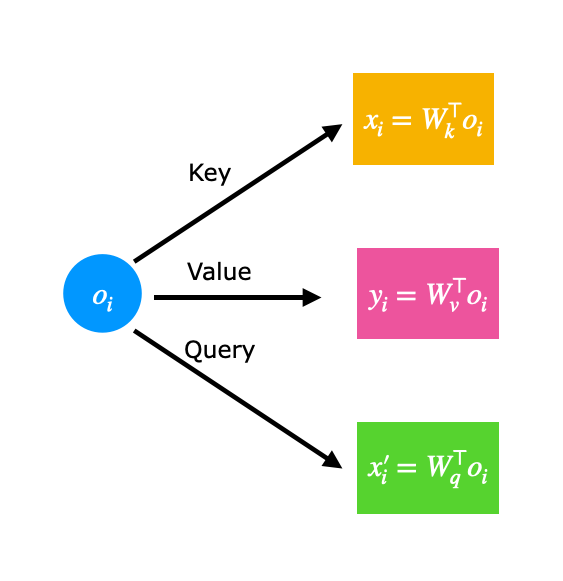
</div>



The self-attention layer processes inputs in parallel, i.e., $S(x_i, x')$ can be computed for all $i$ in parallel. 
This is in contrast to recurrent neural networks, which process the data sequentially. 


## Visualizing Attention Weights in BERT

In [4]:
import seaborn as sns 

In [7]:
from transformers import BertTokenizer, BertModel
import torch

model_name = 'bert-base-uncased'
# Download the pre-trained model + tokenizer (a total of 440 MB)
tokenizer = BertTokenizer.from_pretrained(model_name) # to tokenize the text
model = BertModel.from_pretrained(model_name, output_attentions=True)  # PyTorch module

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
sentence = "I love hiking in the tall and snowy mountains"

# Let us tokenize them 
tokens = tokenizer.encode(sentence, return_tensors='pt')
tokenized_sentence = ["<START>"] + tokenizer.tokenize(sentence) + ["<END>"]
print(tokens.shape)
print(tokenized_sentence)
print(tokens, '\n')
# Note: 101 is the <START> token and 102 is the <END> token

with torch.no_grad():
    out = model(tokens)
attention_weights = out.attentions  # 12 attention maps for each layer in the networks

last_layer_attention_weights = attention_weights[-1]
print(last_layer_attention_weights.shape)  # 12 attention heads (i.e., 12 different key-value-query representations for each token)



torch.Size([1, 11])
['<START>', 'i', 'love', 'hiking', 'in', 'the', 'tall', 'and', 'snowy', 'mountains', '<END>']
tensor([[  101,  1045,  2293, 13039,  1999,  1996,  4206,  1998, 20981,  4020,
           102]]) 

torch.Size([1, 12, 11, 11])


In [9]:
attention_weights = torch.cat(attention_weights).detach() # (layer, attn_head, seq_len, seq_len)

num_layers, num_heads, seq_len, _ = attention_weights.shape

attention_weights = attention_weights.permute(2,0,1,3)  # (seq_len, layer, attn_head, seq_len)


Word at position: mountains


Text(33.0, 0.5, 'Head')

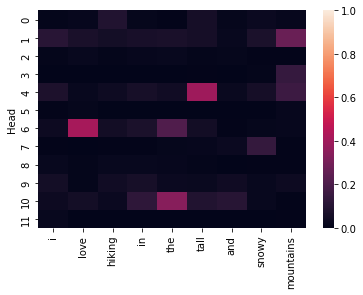

In [10]:
pos = 9
print("Word at position:", tokenizer.decode([tokens[0][pos]]))
attentions_at_pos = attention_weights[pos]

avg_attention = attentions_at_pos[4]  # Choose a certain layer
avg_attention = avg_attention[:, 1:-1]  # Drop start and end tokens
sns.heatmap(avg_attention,vmin=0, vmax = 1, xticklabels=tokenized_sentence[1:-1])

plt.ylabel("Head")

# Part 3: The Transformer Architecture

The transformer architecture puts together self-attention layers with fully connected (MLP) layers together with normalization. 


<div>
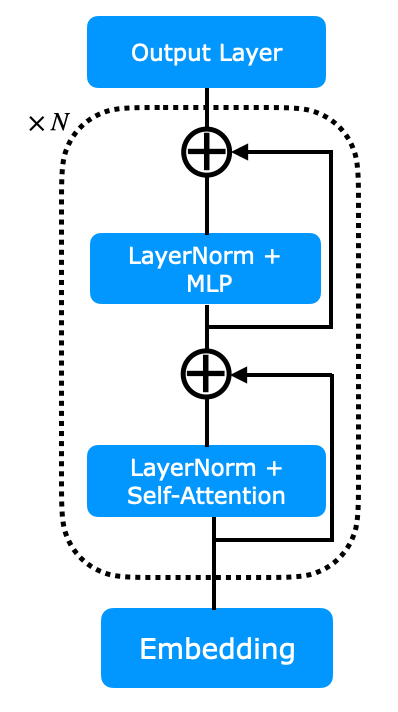
</div>

In PyTorch, a transformer block is defined via the `TransformerEncoderLayer` module. 

**Positional Encoding**: 
Note that the attention mechanism does not take into account any ordering (sequential or otherwise) -- compare with the example on nearest neighbors. 
To endow the model with sequential information, we will augment with word embeddings with positional information. 

In [11]:
max_sequence_length = 25
embedding_dim = 128

pos_embedding_module = torch.nn.Embedding(max_sequence_length, embedding_dim)

input_sequence = torch.LongTensor([23, 39, 23, 12, 58, 28])  # synthetic sequence
position_tensor = torch.arange(input_sequence.shape[0], dtype=torch.long)
print("Position Tensor =", position_tensor)

positional_embedding = pos_embedding_module(position_tensor)
print(positional_embedding.shape)

# TODO: explain this shape?

Position Tensor = tensor([0, 1, 2, 3, 4, 5])
torch.Size([6, 128])


Downstream, we add `positional_embedding` to the corresponding word embeddings. See the transformer module below for details.

**Temporal Masking**: In a sequence model, we can only base the predictions at time $t$ based on the information appearing up to time $t-1$.

**Exercise**: What does this code do? Note that $\exp(-\infty)=0$.

In [ ]:
seq_len = 5
mask = torch.triu(torch.ones(seq_len, seq_len))  # (seq_len, seq_len)
mask.masked_fill_(mask == 0, float('-inf')).masked_fill_(mask == 1, float(0.0))
mask = mask.transpose(0, 1)

print(mask)

# Part 4: Language Modeling with Transformers

We will aim to generate names based on particular language category using a character-level language model. 

We will do this by learning an autoregressive model $P(\text{name}| \text{category})$.


## Define a transformer module
Your task is to answer each of the questions with "TODO" below. 

In [ ]:
import math
import torch
from torch.nn import TransformerEncoderLayer
from torch.nn.functional import softmax, relu

class TransformerModel(torch.nn.Module):
    def __init__(self, num_languages=18, max_seq_len=25, vocab_size=n_letters, input_dim=64, fc_hidden_dim=128,
                 num_attn_heads=2, num_layers=1
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.dims = input_dim
        self.position_tensor = torch.arange(max_seq_len, dtype=torch.long) # (0, 1, ..., max_seq_len - 1)

        # Initialize embeddings
        self.positional_embedding = torch.nn.Embedding(max_seq_len, input_dim)
        self.token_embedding = torch.nn.Embedding(vocab_size, input_dim)
        
        # Handle category inputs
        self.category_embedding = torch.nn.Embedding(num_languages, input_dim)
        
        # Initialize transformer layers
        self.transformer = torch.nn.ModuleList()
        for i in range(num_layers):
            self.transformer.append(
                TransformerEncoderLayer(input_dim, num_attn_heads, fc_hidden_dim, dropout=0,)
            )
        # Initialize final prediction layer
        self.hidden_to_pred = torch.nn.Linear(input_dim, vocab_size)

        # Initialize weights
        with torch.no_grad():
            for w in [self.positional_embedding.weight, self.token_embedding.weight, 
                      self.category_embedding.weight, self.hidden_to_pred.weight]:
                rand_tensor = torch.randn_like(w)
                w.copy_(rand_tensor)
  
    @staticmethod
    def prepare_mask(seq_len):
        # TODO: What does this code do? 
        mask = torch.triu(torch.ones(seq_len, seq_len))  # (seq_len, seq_len)
        mask.masked_fill_(mask == 0, float('-inf')).masked_fill_(mask == 1, float(0.0))
        mask = mask.transpose(0, 1)
        return mask

    def forward(self, inputs, category):
        # inputs: (seq_len, batch_size); dtype = long (representing token ids)
        # category: (batch_size, num_languages)
        seq_len = inputs.shape[0]
        
        # Prepare mask and positions
        mask = self.prepare_mask(seq_len)  # (seq_len, seq_len)
        position_tensor = self.position_tensor[:seq_len]  # (0, 1, ..., seq_len - 1)

        # Embedding
        # TODO: what does this line of code do?
        token_embedding = self.token_embedding(inputs) * math.sqrt(self.dims)  # (seq_len, batch_size, embed_dim)
        
        # TODO: what does this line of code do?
        pos_embedding = self.positional_embedding(position_tensor) # (seq_len, embed_dim)
        pos_embedding = pos_embedding[:, None, :]  # (seq_len, 1, embed_dim); broadcast across batch
        
        # TODO: what does this line of code do?
        category_embedding = self.category_embedding(category)  # (batch_size, embed_dim)
        category_embedding = category_embedding[None, :, :]  # (1, batch_size, embed_dim); broadcast across seq_len
        
        total_embedding = token_embedding + pos_embedding + category_embedding # (seq_len, batch_size, embed_dim)
        hidden = relu(total_embedding)  # (seq_len, batch_size, embed_dim)
        
        # Apply transformer layers
        for transformer_layer in self.transformer:
            hidden = transformer_layer(hidden, mask)  # (seq_len, batch_size, embed_dim)

        # Get the final scores
        outputs = self.hidden_to_pred(hidden)  # (seq_len, batch_size, vocab_size)
        return outputs 


In [ ]:
def input_to_indices(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(len(line))]
    return torch.LongTensor([letter_indexes]).T  # (seq_len, batch_size); batch_size = 1 

# LongTensor of second letter to end (EOS) for target
def target_to_indices(line):
    # Skip the first one and add EOS at the end
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor([letter_indexes]).T  # (seq_len, batch_size); batch_size = 1 


### Data Preprocessing

Download the data from 
[this link](https://download.pytorch.org/tutorial/data.zip) 
and extract it to the current directory.
Look into the folder `data/names`, and make sure that 18 files such as `Arabic.txt`, `Chinese.txt`, etc. are available.


In [ ]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

# Turn a Unicode string to plain ASCII
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in glob.glob('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)

print(n_letters)

## Training loop
We are now ready to train the transformer model.

In [ ]:
from torch.nn.functional import cross_entropy
import time
from tqdm.auto import tqdm

def train_sgd_one_pass(model, total_num_examples, learning_rate):
    avg_loss = 0.0
    for i in tqdm(np.arange(total_num_examples)):  # ~2 min per epoch
        # sample a random training example
        category, input_line, target_line = sample_one_example()
        # Obtain predictions
        predictions = model(input_line, category)  # (seq_len, batch_size, vocab_size)
        
        # Compute the loss
        flattened_predictions = predictions.view(-1, predictions.shape[-1])  # (seq_len * batch_size, vocab_size)
        flattened_targets = target_line.view(-1)  # (seq_len * batch_size)
        loss = cross_entropy(flattened_predictions, flattened_targets)
        
        # TODO: your code for the Gradients and SGD update
        
                
        avg_loss = i / (i+1) * avg_loss + loss.item() / (i+1)
        if i % 5000 == 0:
            print('\t\t', i, avg_loss)
    return avg_loss

This is how we sample a single random example.

In [ ]:
import numpy as np

# Make category, input, and target tensors from a random category, line pair
def sample_one_example():
    # sample category
    category = np.random.choice(all_categories)
    category_tensor = torch.LongTensor([all_categories.index(category)])
    # sample line from category
    line = np.random.choice(category_lines[category]) 
    input_line_tensor = input_to_indices(line)
    target_line_tensor = target_to_indices(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [ ]:
total_num_examples = sum([len(category_lines[c]) for c in all_categories])
print(total_num_examples)

In [ ]:
n_letters

# Train
We are now ready to train the model. We will train it for 5 epochs through our data. 

In [ ]:
model = TransformerModel()
learning_rate = # TODO: find the divergent learning rate to come up with a good initial learning rate


start = time.time()

for epoch in range(10):
    t1 = time.time()
    print(f'Starting epoch {epoch}')
    avg_loss = train_sgd_one_pass(model, total_num_examples, learning_rate)
    print(epoch+1, '\t', round(avg_loss, 3), 
          f'\t{round(time.time()-t1, 2)}sec')
    


## Generating new names from the network

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-  Create tensors for input category, starting letter, and empty hidden
   state
-  Create a string ``output_name`` with the starting letter
-  Up to a maximum output length,

   -  Feed the current letter to the network
   -  Get the next letter from highest output, and next hidden state
   -  If the letter is EOS, stop here
   -  If a regular letter, add to ``output_name`` and continue

-  Return the final name


In [ ]:
max_length = 20

# Generate from a category and starting letter
@torch.no_grad()
def generate_name_greedy(category, start_letter):
    category_tensor = torch.LongTensor([all_categories.index(category)])

    output_name = start_letter
    for i in range(max_length):
        inp = input_to_indices(output_name)
        output = model(inp, category_tensor) # (seq_len, 1, n_letter)
        output = output[-1, 0, :]  # (n_letter,)
        _, next_letter = output.topk(1)
        next_letter = next_letter.item()
        if next_letter == n_letters - 1:  # EOS token
            break
        else:
            output_name += all_letters[next_letter]
        
    return output_name

In [ ]:
print(all_categories)

In [ ]:
generate_name_greedy('French', start_letter='J')

We can also sample from the network for names.

In [ ]:
from torch.nn.functional import softmax

# Generate from a category and starting letter
@torch.no_grad()
def generate_name_sample(category, start_letter, temperature=1):
    category_tensor = torch.LongTensor([all_categories.index(category)])
    output_name = start_letter
    for i in range(max_length):
        inp = input_to_indices(output_name)
        output = model(inp, category_tensor)  # (seq_len, 1, n_letter)
        output = output[-1, 0, :]  # (n_letter,)
        probabilities = softmax(output / temperature, dim=0)
        next_letter = torch.multinomial(probabilities, 1)[0].item()
        if next_letter == n_letters - 1:  # EOS token
            break
        else:
            letter = all_letters[next_letter]
            output_name += letter
        
    return output_name

In [ ]:
print(all_categories)

In [ ]:
for i in range(10):
    print(generate_name_sample('Japanese', start_letter='H'))

In [ ]:
generate_name_sample('Chinese', start_letter='Z')